In [17]:
%matplotlib inline
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from glob import glob
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout , GlobalAveragePooling2D
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from keras.utils import to_categorical
import cv2 as cv
from sklearn.utils import resample


print(os.listdir("../input"))

['diabetic-retinopathy-resized', 'vgg16weights', 'diabetic-retinopathy-224x224-gaussian-filtered', 'resnet-50', 'd']


In [18]:
image_dir = "/kaggle/input/diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped"
image_size = 224

In [19]:
def enhance_color(image):
    image = cv.resize(image, (image_size, image_size))
    image=cv.addWeighted ( image, 4, cv.GaussianBlur( image , (0,0) , 10) ,-4 ,128)
    return image

In [20]:
print('number of images in total - ',len(os.listdir(image_dir)))

number of images in total -  35108


In [21]:
train_labels = pd.read_csv("/kaggle/input/diabetic-retinopathy-resized/trainLabels_cropped.csv") 
print('number of labels in total - ',len(train_labels))

number of labels in total -  35108


In [22]:
train_labels['image_name'] = [i+".jpeg" for i in train_labels['image'].values] #format correctly
train_labels.drop(columns=['image'], inplace=True)

In [23]:
train_labels.head()

,Unnamed: 0.1,Unnamed: 0,level,image_name
0,0,0,0,10_left.jpeg
1,1,1,0,10_right.jpeg
2,2,2,0,13_left.jpeg
3,3,3,0,13_right.jpeg
4,4,4,1,15_left.jpeg


<Axes: >

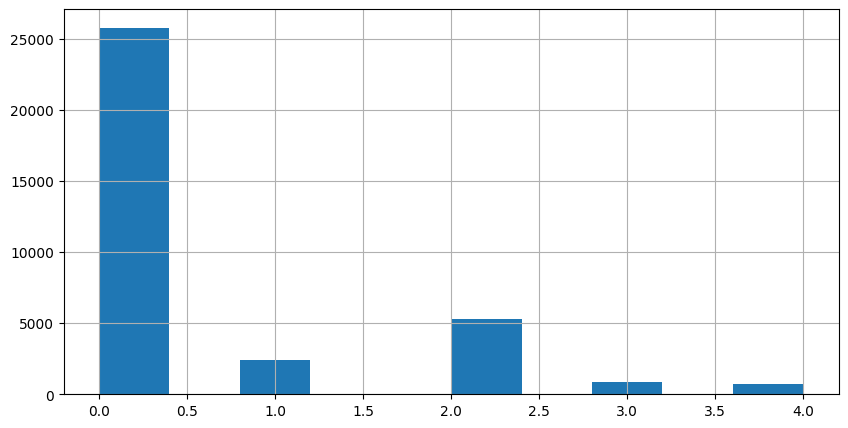

In [24]:
train_labels['level'].hist(figsize = (10, 5))

In [25]:
'''from sklearn.utils import resample

class_0_samples = train_labels[train_labels['level'] == 0]
class_1_samples = train_labels[train_labels['level'] == 1]
class_2_samples = train_labels[train_labels['level'] == 2]
class_3_samples = train_labels[train_labels['level'] == 3]
class_4_samples = train_labels[train_labels['level'] == 4]

num_class_2_samples = len(class_2_samples)

undersampled_data = pd.concat([
    resample(train_labels[train_labels['level'] == level], 
             replace=False, 
             n_samples=num_class_2_samples,  
             random_state=0  
            )
    for level in range(0, 1) 
])

# Combine the undersampled data 
balanced_data = pd.concat([undersampled_data, class_1_samples, class_2_samples, class_3_samples, class_4_samples])

balanced_data['level'].hist(figsize = (10, 5))'''

"from sklearn.utils import resample\n\nclass_0_samples = train_labels[train_labels['level'] == 0]\nclass_1_samples = train_labels[train_labels['level'] == 1]\nclass_2_samples = train_labels[train_labels['level'] == 2]\nclass_3_samples = train_labels[train_labels['level'] == 3]\nclass_4_samples = train_labels[train_labels['level'] == 4]\n\nnum_class_2_samples = len(class_2_samples)\n\nundersampled_data = pd.concat([\n    resample(train_labels[train_labels['level'] == level], \n             replace=False, \n             n_samples=num_class_2_samples,  \n             random_state=0  \n            )\n    for level in range(0, 1) \n])\n\n# Combine the undersampled data \nbalanced_data = pd.concat([undersampled_data, class_1_samples, class_2_samples, class_3_samples, class_4_samples])\n\nbalanced_data['level'].hist(figsize = (10, 5))"

In [26]:
train, val = train_test_split(train_labels, test_size=0.2, random_state=0, stratify=train_labels["level"])
val, test = train_test_split(val, test_size=0.5, random_state=0, stratify=val["level"])
train.shape, val.shape, test.shape

((28086, 4), (3511, 4), (3511, 4))

In [27]:
# Data Augmentation
train_datagen = ImageDataGenerator(rescale            = 1/255,
                                   shear_range        = 0.3,
                                   zoom_range         = 0.2,
                                   horizontal_flip    = True,
                                   vertical_flip      = True,
                                   rotation_range     = 360,
                                   fill_mode          = 'constant',
                                   preprocessing_function = enhance_color,
                                                            )

val_datagen = ImageDataGenerator(rescale = 1/255)

In [28]:
# Data Loading
train_set = train_datagen.flow_from_dataframe(
    train,
    image_dir,
    x_col="image_name",
    y_col="level",
    class_mode="raw",
    color_mode="rgb",
    batch_size=32,
    target_size=(224, 224))

val_set = val_datagen.flow_from_dataframe(
    val,
    image_dir,
    x_col="image_name",
    y_col="level",
    class_mode="raw",
    color_mode="rgb",
    batch_size=32,
    target_size=(224, 224))

Found 28086 validated image filenames.
Found 3511 validated image filenames.


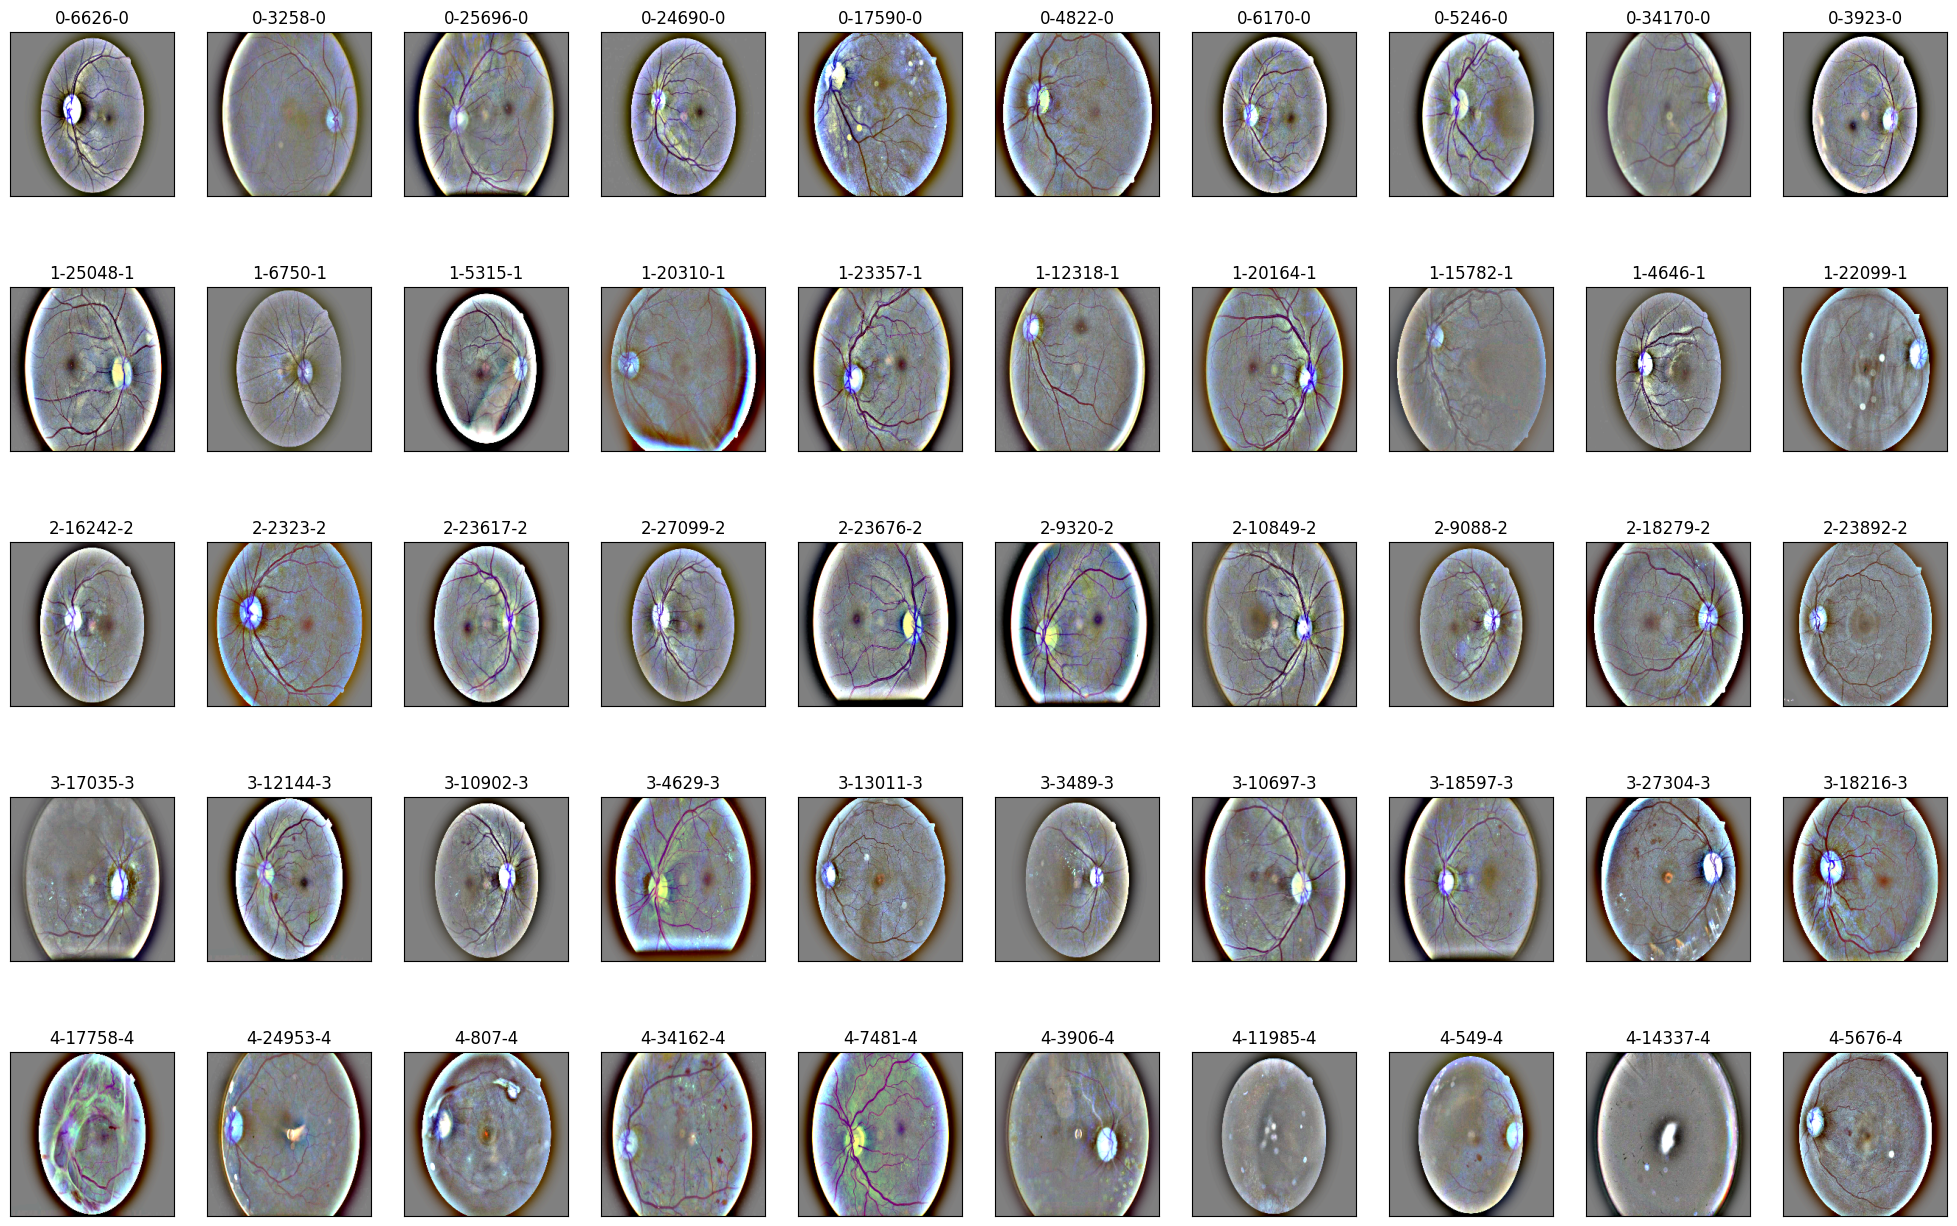

In [29]:
NUM_SAMP=10
fig = plt.figure(figsize=(25, 16))
for class_id in range(5):
    for i, (idx, row) in enumerate(train_labels.loc[train_labels['level'] == class_id].sample(NUM_SAMP, random_state=77).iterrows()):
        ax = fig.add_subplot(5, NUM_SAMP, class_id * NUM_SAMP + i + 1, xticks=[], yticks=[])
        path=f"../input/diabetic-retinopathy-resized/resized_train/resized_train/{row['image_name']}"
        image = cv.imread(path)
        image = enhance_color(image)

        if image is not None:
            plt.imshow(image)
            ax.set_title('%d-%d-%s' % (class_id, idx, row['level']) )

In [33]:
initial_model = Sequential([
    Conv2D(128, (3, 3), activation='relu', input_shape=(image_size, image_size, 3), padding='same'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation = 'relu'),
    Dropout(0.5),
    Dense(5, activation = 'softmax') 
])

In [35]:
optimizer = keras.optimizers.Adam(learning_rate=0.01)

In [37]:
initial_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [38]:
initial_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 224, 224, 128)     3584      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 112, 112, 128)    0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 112, 112, 64)      73792     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 56, 56, 32)        18464     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 28, 28, 32)      

In [ ]:
custom_model = Sequential([

Conv2D(256, (5, 5),activation='relu', input_shape=(image_size, image_size, 3) ),
MaxPooling2D(pool_size=(2, 2)),

Conv2D(128,  (4, 4), activation='relu'),
MaxPooling2D(pool_size=(2, 2)),

Conv2D(64, (3, 3), activation='relu'),
MaxPooling2D(pool_size=(2, 2)),
    
Conv2D(32, (3, 3), activation='relu'),
MaxPooling2D(pool_size=(2, 2)),

Flatten(),
Dense(128, activation = 'relu'),
Dense(64,  activation = 'relu'),
Dense(32,  activation = 'relu'),
Dropout(0.5),
Dense(5, activation = 'softmax') ])

In [ ]:
# from keras.applications.vgg19 import VGG19
# import keras.layers as L
# from keras.models import Model

In [ ]:
# base_model = VGG19(weights=None,
#                    include_top=False,
#                    input_shape=(224, 224, 3))
# x = base_model.output
# x = L.GlobalMaxPooling2D()(x)
# x = L.BatchNormalization()(x)
# x = L.Dropout(0.4)(x)
# x = L.Dense(1024, activation="relu")(x)
# x = L.Dropout(0.2)(x)
# x = L.Dense(64, activation="relu")(x)
# predictions = L.Dense(5, activation='softmax')(x)

In [ ]:
#model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
#for layer in base_model.layers[:18]: layer.trainable = False

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.01)

In [ ]:
custom_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
# model_chk = ModelCheckpoint("vgg19_model_New.h5", save_best_only=True, monitor="val_accuracy")
# reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',  # Metric to monitor
#                               factor=0.5,         # Factor by which the learning rate will be reduced
#                               patience=2,         # Number of epochs with no improvement after which the learning rate will be reduced
#                               min_lr=1e-6 )

In [ ]:
# model.fit(train_set, validation_data = val_set,
#                     epochs=10, workers=8, callbacks=[model_chk, reduce_lr])

In [ ]:
custom_model.summary()

In [ ]:
model_train = custom_model.fit(train_set, validation_data = val_set,
                    epochs=10, workers=8)

In [ ]:
epochs=range(1,len(model_train.history['val_loss'])+1)

plt.title('Model Accuracy')
plt.plot(epochs,model_train.history['accuracy'])
plt.plot(epochs,model_train.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

plt.plot(epochs,model_train.history['loss'])
plt.plot(epochs,model_train.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Assuming you've trained your model and have the test data and true labels
test_generator = val_datagen.flow_from_dataframe(
    test,
    image_dir,
    x_col="image_name",
    y_col="level",
    class_mode="raw",
    color_mode="rgb",
    batch_size=32,
    target_size=(224, 224))

# Evaluate the model on the test set
test_loss, test_accuracy = custom_model.evaluate(test_generator)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Make predictions on the test set
y_true = test['level'].values
y_pred = custom_model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)

# Compute other performance metrics like precision, recall, and F1-score
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")




In [ ]:
# Compute the confusion matrix
confusion = confusion_matrix(y_true, y_pred)
import seaborn as sns
# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1,2,3,4], yticklabels=[0,1,2,3,4])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()